# Neural Networks

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
def load_data(file_path, batch_size=64):
    data = pd.read_csv(file_path)
    Y = data['label'].values
    X = data.drop(columns=['label'], axis=1).values
    X = X/255.0  # Normalize features
    # Split the data 60-20-20 for train, validation, and test
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, stratify=Y, random_state=30)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=30)

    # Create TensorDatasets for each split
    # Convert data (numpy arrays) to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(Y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                torch.tensor(Y_val, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                 torch.tensor(Y_test, dtype=torch.long))

    # Data loaders for batching and shuffling the data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=[128, 64], layers=2, output_size=10, dropout_prob=0.5):
        super(NeuralNetwork, self).__init__()
        self.layers = layers
        self.relu = nn.ReLU()
        self.best_val_loss = float('inf')
        self.best_model_state = None
        self.dropout = nn.Dropout(dropout_prob)

        # Create hidden layers dynamically
        # fc1, fc2, ..., fcN (input_size -> hidden_size[0], hidden_size[i-1] -> hidden_size[i])
        # fc stands for fully connected layer
        for i in range(self.layers):
            if i == 0:
                setattr(self, f'fc{i+1}', nn.Linear(input_size, hidden_size[i]))
            else:
                setattr(self, f'fc{i+1}', nn.Linear(hidden_size[i-1], hidden_size[i]))
        # Output layer
        setattr(self, f'fc{self.layers + 1}', nn.Linear(hidden_size[-1], output_size))

        # Weight initialization (He)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        for i in range(self.layers):
            fc_layer = getattr(self, f'fc{i+1}')
            x = fc_layer(x)
            x = self.relu(x)
            x = self.dropout(x)
        output_layer = getattr(self, f'fc{self.layers + 1}')
        return output_layer(x)


    def train_model(self, train_loader, val_loader, loss_function, optimizer, epochs=10, patience=3):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_losses, val_losses = [], []
        train_std, val_std = [], []
        train_accuracies, val_accuracies = [], []
        self.early_stopping_counter = 0

        for epoch in range(epochs):
            self.train()
            epoch_losses = []
            correct_train, total_train = 0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                # Zero the gradients as optimizer accumulates them
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                # Backpropagation (compute gradients dL/dW)
                loss.backward()
                # Update weights (W = W - lr * dL/dW)
                optimizer.step()

                epoch_losses.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            avg_train_loss = torch.tensor(epoch_losses).mean().item()
            std_train_loss = torch.tensor(epoch_losses).std().item()
            train_losses.append(avg_train_loss)
            train_std.append(std_train_loss)
            train_accuracies.append(correct_train / total_train)

            self.eval()
            val_batch_losses = []
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    loss = loss_function(outputs, labels)
                    val_batch_losses.append(loss.item())

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            avg_val_loss = torch.tensor(val_batch_losses).mean().item()
            std_val_loss = torch.tensor(val_batch_losses).std().item()
            val_losses.append(avg_val_loss)
            val_std.append(std_val_loss)
            val_accuracies.append(correct_val / total_val)

            # ---- LOGGING ----
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} ± {std_val_loss:.4f} | "
                  f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

            # ---- EARLY STOPPING ----
            if avg_val_loss < self.best_val_loss:
                self.best_val_loss = avg_val_loss
                self.best_model_state = self.state_dict()
                # torch.save(self.best_model_state, 'best_model.pth')
                self.early_stopping_counter = 0
                # print("New best model saved.")
            else:
                self.early_stopping_counter += 1
                if self.early_stopping_counter >= patience:
                    print("No improvement, stopping early.")
                    break

        return self.best_model_state, train_losses, val_losses, train_std, val_std, train_accuracies, val_accuracies

    def evaluate_model(self, test_loader, loss_function):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.eval()
        test_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = correct / total
        print(f'\n Test Loss: {avg_test_loss:.4f}')
        print(f'Test Accuracy: {test_accuracy:.4f}')
        return avg_test_loss, test_accuracy

    @staticmethod
    def plot_results(train_losses, val_losses, train_std, val_std, train_accuracies, val_accuracies):
        epochs = range(1, len(train_losses) + 1)
        loss_gap = [abs(t - v) for t, v in zip(train_losses, val_losses)]  # convergence metric

        plt.figure(figsize=(15, 4))

        # (1) Loss curves with error bars
        plt.subplot(1, 3, 1)
        plt.errorbar(epochs, train_losses, yerr=train_std, label='Train Loss', capsize=3)
        plt.errorbar(epochs, val_losses, yerr=val_std, label='Validation Loss', capsize=3)
        plt.xlabel('Epochs'); plt.ylabel('Loss')
        plt.title('Learning Curve (with Error Bars)')
        plt.legend(); plt.grid(True)

        # (2) Accuracy curves
        plt.subplot(1, 3, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy')
        plt.title('Learning Curve (Accuracy)')
        plt.legend(); plt.grid(True)

        # (3) Convergence analysis
        plt.subplot(1, 3, 3)
        plt.plot(epochs, loss_gap, color='purple', label='|Train - Val Loss| (Convergence Analysis)')
        plt.xlabel('Epochs'); plt.ylabel('Loss Gap')
        plt.title('Convergence Analysis')
        plt.legend(); plt.grid(True)

        plt.tight_layout()
        plt.show()

In [4]:
def convergence_speed(val_losses):
    best_loss = val_losses[0]
    for i in range(1, len(val_losses)):
        if abs(val_losses[i] - best_loss) / best_loss < 0.001:
            return i
        best_loss = min(best_loss, val_losses[i])
    return len(val_losses)
def stability_measure(val_losses):
    tail = val_losses[-5:] if len(val_losses) >= 5 else val_losses
    return np.std(tail)
def gradient_noise_measure(train_losses):
    diffs = np.diff(train_losses)
    return np.var(diffs)

In [5]:
def run_learning_rate_analysis():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, val_loader, _ = load_data('mnist_All.csv', batch_size=64)

    results = {}
    learning_rates = [0.001, 0.01, 0.1, 1.0]
    print("\n===== Learning Rate Analysis =====")

    for lr in learning_rates:
        print(f"\nTesting Learning Rate = {lr}")
        model = NeuralNetwork(input_size=784, hidden_size=[128, 64], layers=2, output_size=10).to(device)
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        best_model_state, train_losses, val_losses, train_std, val_std, train_acc, val_acc = model.train_model(
            train_loader, val_loader, loss_function, optimizer, epochs=100, patience=5)

        conv_speed = convergence_speed(val_losses)
        stability = stability_measure(val_losses)

        results[lr] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'convergence_speed': conv_speed,
            'stability': stability
        }
    # Best learning rate based on maximum validation accuracy
    best_lr = max(results, key=lambda x: max(results[x]['val_acc']))
    best_lr_acc = max(results[best_lr]['val_acc'])
    print(f"\n Best Learning Rate: {best_lr} (Val Accuracy: {best_lr_acc:.4f})")
    return results, best_lr, best_lr_acc


In [6]:

def plot_learning_rate_analysis(results):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 10))
    plt.suptitle('Learning Rate Analysis', fontsize=14, fontweight='bold')

    # (1) Train Loss
    plt.subplot(2, 2, 1)
    for lr, data in results.items():
        plt.plot(data['train_losses'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (2) Validation Loss
    plt.subplot(2, 2, 2)
    for lr, data in results.items():
        plt.plot(data['val_losses'], label=f'LR={lr} (conv={data["convergence_speed"]}, stab={data["stability"]:.4f})')
    plt.xlabel('Epochs'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (3) Train Accuracy
    plt.subplot(2, 2, 3)
    for lr, data in results.items():
        plt.plot(data['train_acc'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (4) Validation Accuracy
    plt.subplot(2, 2, 4)
    for lr, data in results.items():
        plt.plot(data['val_acc'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [7]:
def run_batch_size_analysis():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    results = {}
    batch_sizes = [16, 32, 64, 128]
    print("\n===== Batch Size Analysis =====")

    for bs in batch_sizes:
        print(f"\nTesting Batch Size = {bs}")
        train_loader, val_loader, test_loader = load_data('mnist_All.csv', batch_size=bs)

        model = NeuralNetwork(input_size=784, hidden_size=[128, 64], layers=2, output_size=10).to(device)
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

        best_model_state, train_losses, val_losses, train_std, val_std, train_acc, val_acc = model.train_model(
            train_loader, val_loader, loss_function, optimizer, epochs=100, patience=5)

        grad_noise = gradient_noise_measure(train_losses)

        results[bs] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'gradient_noise': grad_noise
        }

    best_bs = max(results, key=lambda x: max(results[x]['val_acc']))
    best_bs_acc = max(results[best_bs]['val_acc'])
    print(f"\n Best Batch Size: {best_bs} (Val Accuracy: {best_bs_acc:.4f})")

    return results, best_bs, best_bs_acc


In [8]:
def plot_batch_size_analysis(results):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 10))
    plt.suptitle('Batch Size Analysis', fontsize=14, fontweight='bold')

    # (1) Train Loss
    plt.subplot(2, 2, 1)
    for bs, data in results.items():
        plt.plot(data['train_losses'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (2) Validation Loss
    plt.subplot(2, 2, 2)
    for bs, data in results.items():
        plt.plot(data['val_losses'], label=f'BS={bs} (grad_noise={data["gradient_noise"]:.4f})')
    plt.xlabel('Epochs'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (3) Train Accuracy
    plt.subplot(2, 2, 3)
    for bs, data in results.items():
        plt.plot(data['train_acc'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    # (4) Validation Accuracy
    plt.subplot(2, 2, 4)
    for bs, data in results.items():
        plt.plot(data['val_acc'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [9]:
def run_architecture_analysis():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, val_loader, _ = load_data('mnist_All.csv', batch_size=64)

    results = {}
    layer_options = [2, 3, 4, 5]
    neuron_options = [64, 128, 256, 512]

    print("\n===== Architecture Analysis =====")

    for layers in layer_options:
        for neurons in neuron_options:
            print(f"\nTesting Architecture: Layers={layers}, Neurons={neurons}")
            hidden_size = [neurons] * layers

            model = NeuralNetwork(input_size=784, hidden_size=hidden_size, layers=layers, output_size=10).to(device)
            loss_function = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

            best_model_state, train_losses, val_losses, train_std, val_std, train_acc, val_acc = model.train_model(
                train_loader, val_loader, loss_function, optimizer, epochs=100, patience=5)

            conv_speed = convergence_speed(val_losses)
            stability = stability_measure(val_losses)

            results[(layers, neurons)] = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'convergence_speed': conv_speed,
                'stability': stability
            }

    # ---- Find best architecture ----
    best_arch = max(results, key=lambda x: max(results[x]['val_acc']))
    best_acc = max(results[best_arch]['val_acc'])
    print(f"\n Best Architecture: Layers={best_arch[0]}, Neurons={best_arch[1]} (Val Accuracy: {best_acc:.4f})")

    # ---- Create comparison table ----
    table_data = []
    for (layers, neurons), data in results.items():
        table_data.append({
            'Layers': layers,
            'Neurons': neurons,
            'Best_Val_Accuracy': max(data['val_acc']),
            'Convergence_Speed': data['convergence_speed'],
            'Stability': data['stability']
        })

    df = pd.DataFrame(table_data).sort_values(by='Best_Val_Accuracy', ascending=False)
    print("\n=== Architecture Comparison Table ===")
    print(df.to_string(index=False))

    return results, df, best_arch, best_acc


In [10]:
def plot_architecture_analysis(results):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 10))
    plt.suptitle('Architecture Analysis', fontsize=14, fontweight='bold')

    # (1) Train Loss
    plt.subplot(2, 2, 1)
    for (layers, neurons), data in results.items():
        plt.plot(data['train_losses'], label=f'L={layers}, N={neurons}')
    plt.xlabel('Epochs'); plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend(fontsize=7); plt.grid(True)

    # (2) Validation Loss
    plt.subplot(2, 2, 2)
    for (layers, neurons), data in results.items():
        plt.plot(data['val_losses'], label=f'L={layers}, N={neurons}')
    plt.xlabel('Epochs'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs Epochs')
    plt.legend(fontsize=7); plt.grid(True)

    # (3) Train Accuracy
    plt.subplot(2, 2, 3)
    for (layers, neurons), data in results.items():
        plt.plot(data['train_acc'], label=f'L={layers}, N={neurons}')
    plt.xlabel('Epochs'); plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy vs Epochs')
    plt.legend(fontsize=7); plt.grid(True)

    # (4) Validation Accuracy
    plt.subplot(2, 2, 4)
    for (layers, neurons), data in results.items():
        plt.plot(data['val_acc'], label=f'L={layers}, N={neurons}')
    plt.xlabel('Epochs'); plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.legend(fontsize=7); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_architecture_surface(df):
    # Prepare data
    layers = sorted(df['Layers'].unique())
    neurons = sorted(df['Neurons'].unique())

    # Create grid
    X, Y = np.meshgrid(layers, neurons)
    Z = np.zeros_like(X, dtype=float)

    for i, n in enumerate(neurons):
        for j, l in enumerate(layers):
            row = df[(df['Layers'] == l) & (df['Neurons'] == n)]
            if not row.empty:
                Z[i, j] = row['Best_Val_Accuracy'].values[0]
            else:
                Z[i, j] = np.nan

    # ---- 3D Surface ----
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)
    ax.set_title('3D Surface: Layers vs Neurons vs Accuracy')
    ax.set_xlabel('Layers')
    ax.set_ylabel('Neurons per Layer')
    ax.set_zlabel('Validation Accuracy')
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10)

    # ---- Heatmap ----
    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(Z, annot=True, fmt=".3f", cmap='coolwarm',
                xticklabels=layers, yticklabels=neurons)
    ax2.set_title('Heatmap: Validation Accuracy')
    ax2.set_xlabel('Layers')
    ax2.set_ylabel('Neurons per Layer')

    plt.tight_layout()
    plt.show()


In [11]:
lr_results, best_lr, best_lr_acc = run_learning_rate_analysis()


===== Learning Rate Analysis =====

Testing Learning Rate = 0.001
Epoch [1/100] | Train Loss: 2.1762 ± 0.1342 | Val Loss: 1.9489 ± 0.0511 | Train Acc: 0.2652, Val Acc: 0.4766
Epoch [2/100] | Train Loss: 1.7074 ± 0.1525 | Val Loss: 1.4630 ± 0.0771 | Train Acc: 0.5857, Val Acc: 0.6784
Epoch [3/100] | Train Loss: 1.2592 ± 0.1340 | Val Loss: 1.0720 ± 0.0856 | Train Acc: 0.7318, Val Acc: 0.7796
Epoch [4/100] | Train Loss: 0.9440 ± 0.1100 | Val Loss: 0.8280 ± 0.0889 | Train Acc: 0.7985, Val Acc: 0.8189
Epoch [5/100] | Train Loss: 0.7562 ± 0.0933 | Val Loss: 0.6863 ± 0.0905 | Train Acc: 0.8286, Val Acc: 0.8405
Epoch [6/100] | Train Loss: 0.6441 ± 0.0880 | Val Loss: 0.5994 ± 0.0919 | Train Acc: 0.8484, Val Acc: 0.8546
Epoch [7/100] | Train Loss: 0.5723 ± 0.0894 | Val Loss: 0.5413 ± 0.0927 | Train Acc: 0.8596, Val Acc: 0.8664
Epoch [8/100] | Train Loss: 0.5234 ± 0.0892 | Val Loss: 0.5004 ± 0.0937 | Train Acc: 0.8688, Val Acc: 0.8739
Epoch [9/100] | Train Loss: 0.4875 ± 0.0911 | Val Loss: 0.469

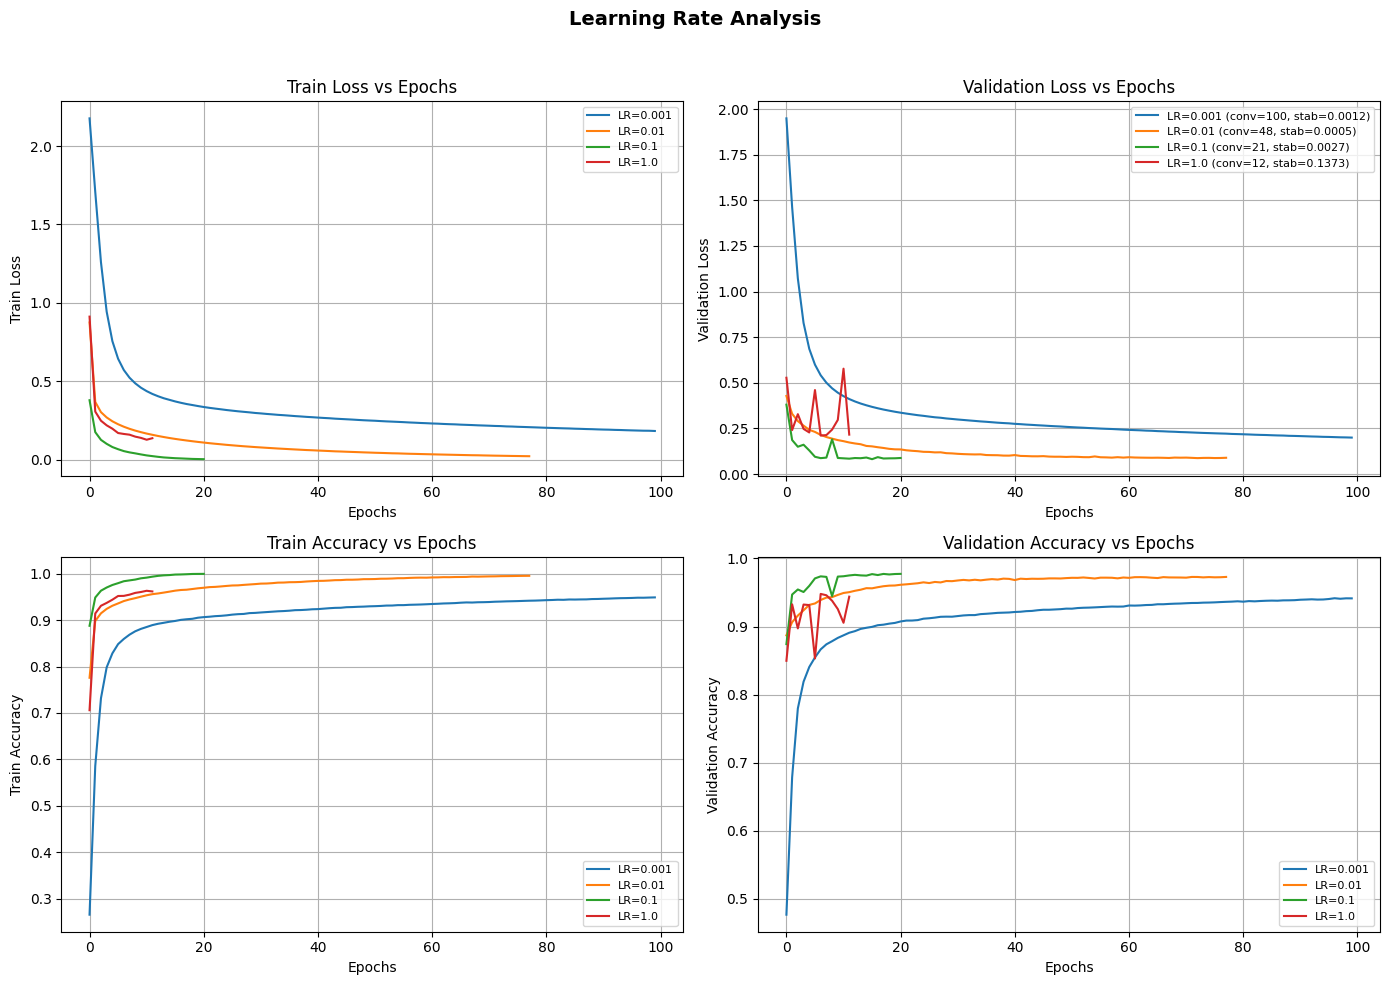

In [12]:
plot_learning_rate_analysis(lr_results)

In [15]:
bs_results, best_bs, best_bs_acc = run_batch_size_analysis()


===== Batch Size Analysis =====

Testing Batch Size = 16
Epoch [1/100] | Train Loss: 0.5040 ± 0.4263 | Val Loss: 0.2850 ± 0.1962 | Train Acc: 0.8599, Val Acc: 0.9188
Epoch [2/100] | Train Loss: 0.2523 ± 0.1829 | Val Loss: 0.2301 ± 0.1796 | Train Acc: 0.9275, Val Acc: 0.9342
Epoch [3/100] | Train Loss: 0.1981 ± 0.1660 | Val Loss: 0.1879 ± 0.1602 | Train Acc: 0.9430, Val Acc: 0.9458
Epoch [4/100] | Train Loss: 0.1631 ± 0.1487 | Val Loss: 0.1611 ± 0.1533 | Train Acc: 0.9537, Val Acc: 0.9536
Epoch [5/100] | Train Loss: 0.1390 ± 0.1327 | Val Loss: 0.1463 ± 0.1415 | Train Acc: 0.9601, Val Acc: 0.9556
Epoch [6/100] | Train Loss: 0.1197 ± 0.1260 | Val Loss: 0.1264 ± 0.1338 | Train Acc: 0.9658, Val Acc: 0.9620
Epoch [7/100] | Train Loss: 0.1051 ± 0.1182 | Val Loss: 0.1177 ± 0.1305 | Train Acc: 0.9698, Val Acc: 0.9656
Epoch [8/100] | Train Loss: 0.0940 ± 0.1110 | Val Loss: 0.1108 ± 0.1249 | Train Acc: 0.9733, Val Acc: 0.9666
Epoch [9/100] | Train Loss: 0.0836 ± 0.1054 | Val Loss: 0.1104 ± 0.128

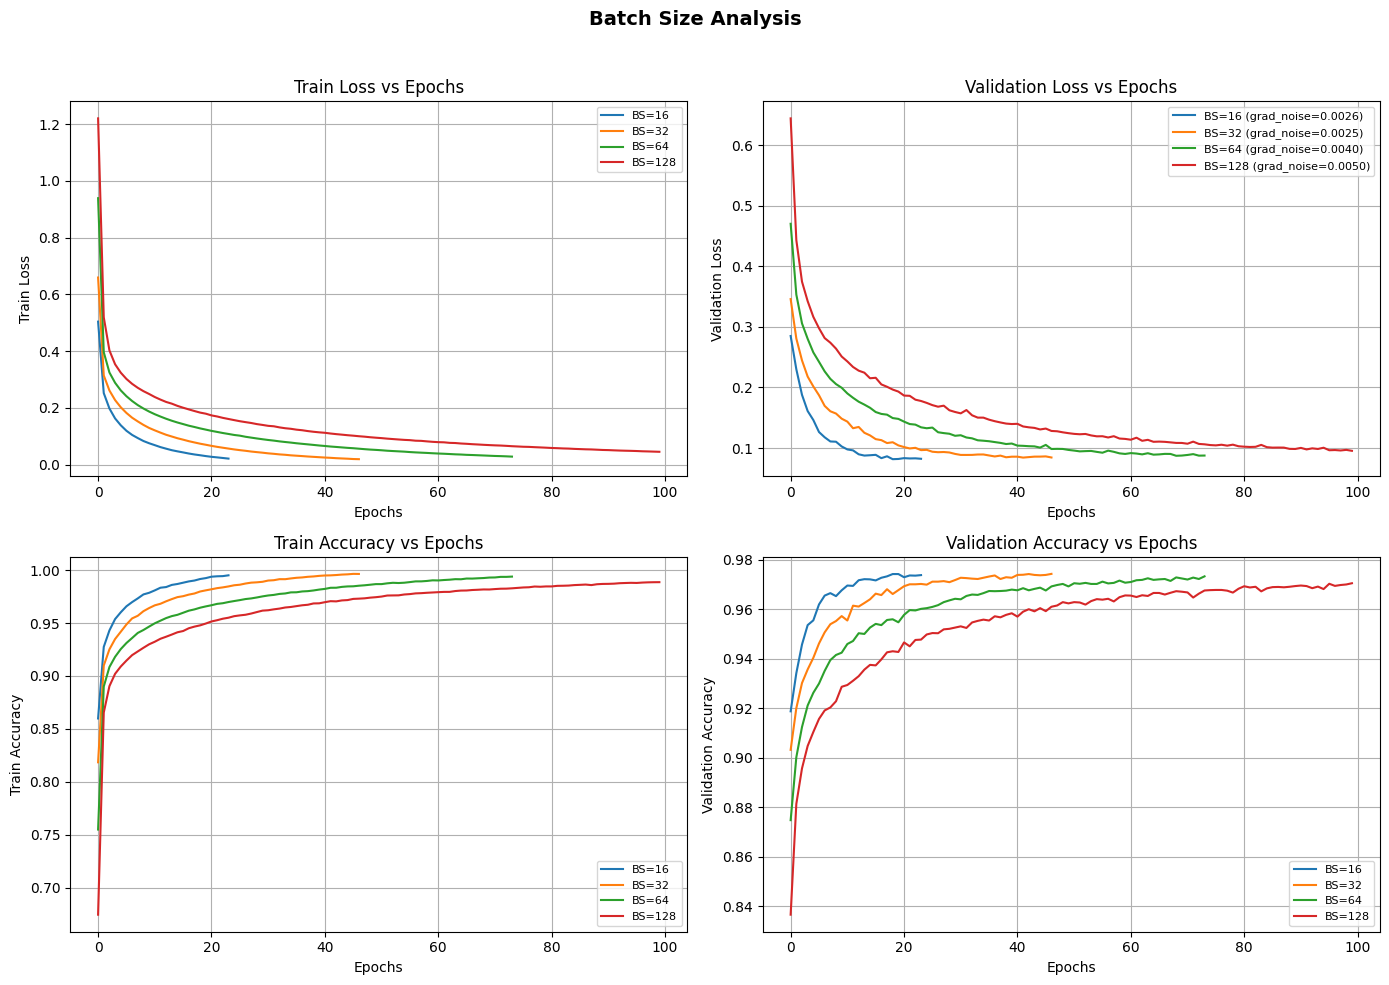

In [16]:
plot_batch_size_analysis(bs_results)

In [17]:
results_arch, df_arch, best_arch, best_acc = run_architecture_analysis()


===== Architecture Analysis =====

Testing Architecture: Layers=2, Neurons=64
Epoch [1/100] | Train Loss: 0.9588 ± 0.5257 | Val Loss: 0.4734 ± 0.0996 | Train Acc: 0.7253, Val Acc: 0.8726
Epoch [2/100] | Train Loss: 0.4060 ± 0.1063 | Val Loss: 0.3525 ± 0.0996 | Train Acc: 0.8861, Val Acc: 0.9002
Epoch [3/100] | Train Loss: 0.3300 ± 0.1019 | Val Loss: 0.3079 ± 0.0984 | Train Acc: 0.9067, Val Acc: 0.9131
Epoch [4/100] | Train Loss: 0.2916 ± 0.0940 | Val Loss: 0.2764 ± 0.0937 | Train Acc: 0.9168, Val Acc: 0.9211
Epoch [5/100] | Train Loss: 0.2657 ± 0.0922 | Val Loss: 0.2614 ± 0.0932 | Train Acc: 0.9245, Val Acc: 0.9233
Epoch [6/100] | Train Loss: 0.2461 ± 0.0934 | Val Loss: 0.2419 ± 0.0907 | Train Acc: 0.9302, Val Acc: 0.9286
Epoch [7/100] | Train Loss: 0.2302 ± 0.0875 | Val Loss: 0.2268 ± 0.0880 | Train Acc: 0.9336, Val Acc: 0.9341
Epoch [8/100] | Train Loss: 0.2167 ± 0.0809 | Val Loss: 0.2183 ± 0.0868 | Train Acc: 0.9373, Val Acc: 0.9357
Epoch [9/100] | Train Loss: 0.2052 ± 0.0816 | Val

## Model Architecture Comparison

**Best Architecture:**  
**Layers = 2**, **Neurons = 512**  
**Validation Accuracy:** **0.9766**

---

###  Architecture Comparison Table

| Layers | Neurons | Best Val Accuracy | Convergence Speed | Stability   |
|:------:|:--------:|:----------------:|:-----------------:|:------------|
| 2 | 512 | **0.976571** | 30 | 0.000314 |
| 3 | 512 | 0.976571 | 23 | 0.001905 |
| 4 | 512 | 0.975714 | 33 | 0.003217 |
| 3 | 256 | 0.975500 | 9 | 0.000484 |
| 2 | 256 | 0.975214 | 48 | 0.000304 |
| 2 | 128 | 0.974500 | 67 | 0.000866 |
| 5 | 512 | 0.974143 | 26 | 0.001464 |
| 5 | 256 | 0.974071 | 4 | 0.009686 |
| 4 | 256 | 0.973286 | 34 | 0.005641 |
| 3 | 128 | 0.972857 | 30 | 0.001219 |
| 5 | 128 | 0.972000 | 26 | 0.084308 |
| 4 | 128 | 0.971143 | 34 | 0.004879 |
| 4 | 64 | 0.970000 | 36 | 0.003325 |
| 2 | 64 | 0.969143 | 34 | 0.000314 |
| 3 | 64 | 0.968214 | 20 | 0.004066 |
| 5 | 64 | 0.963857 | 22 | 0.001132 |

---

**Notes:**
-  The model with **2 layers** and **512 neurons** achieved the **highest validation accuracy (0.9766)**.  
- Lower convergence speed indicates faster training.  
- Stability measures variance in validation accuracy across epochs — lower is better.


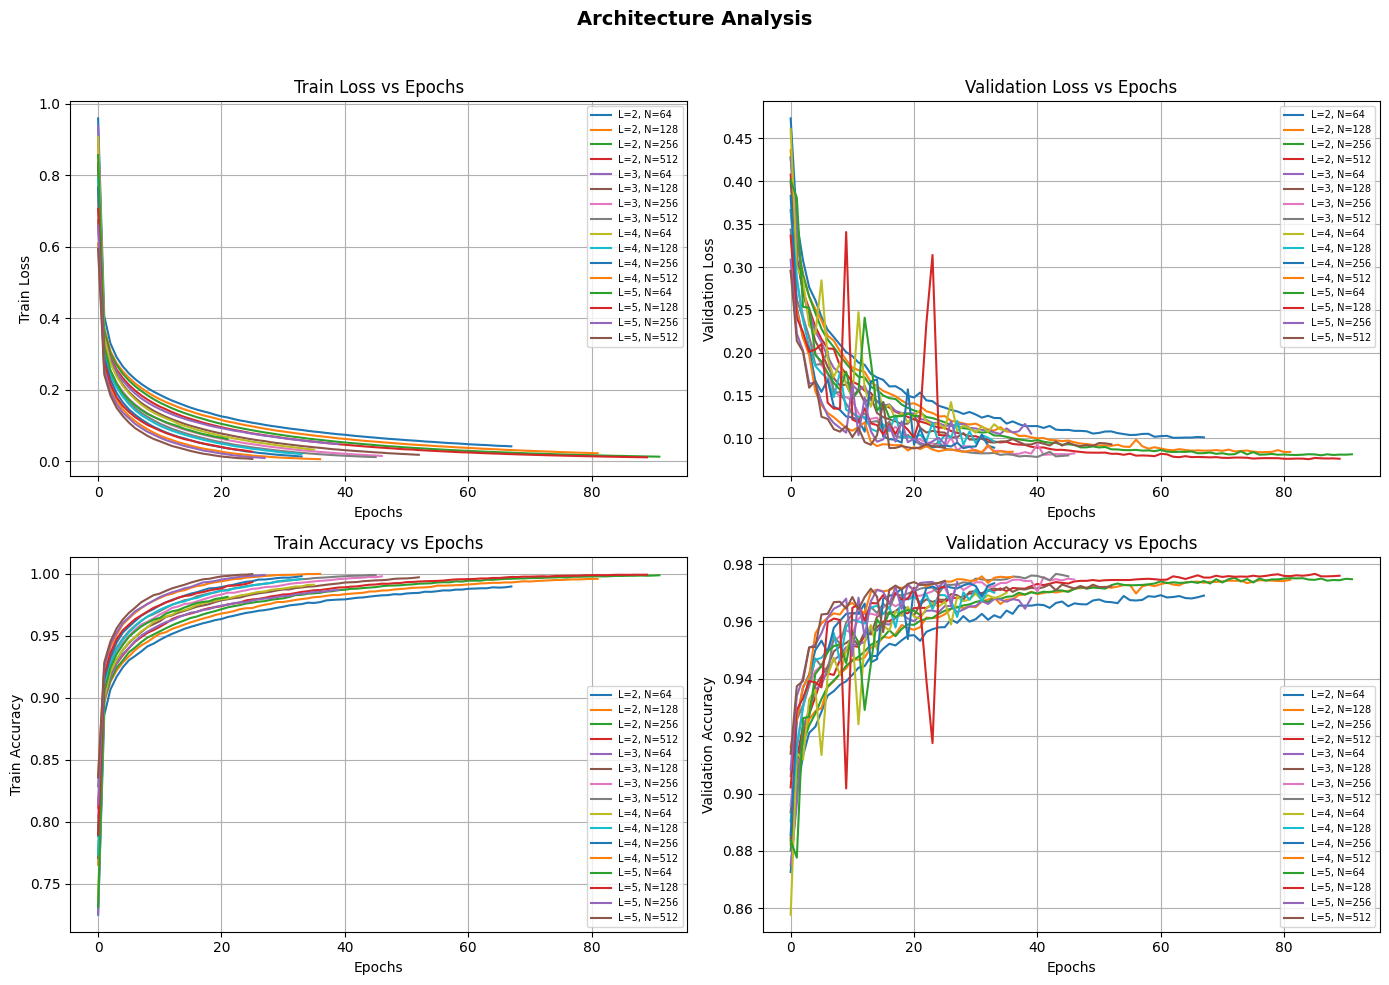

In [18]:
plot_architecture_analysis(results_arch)

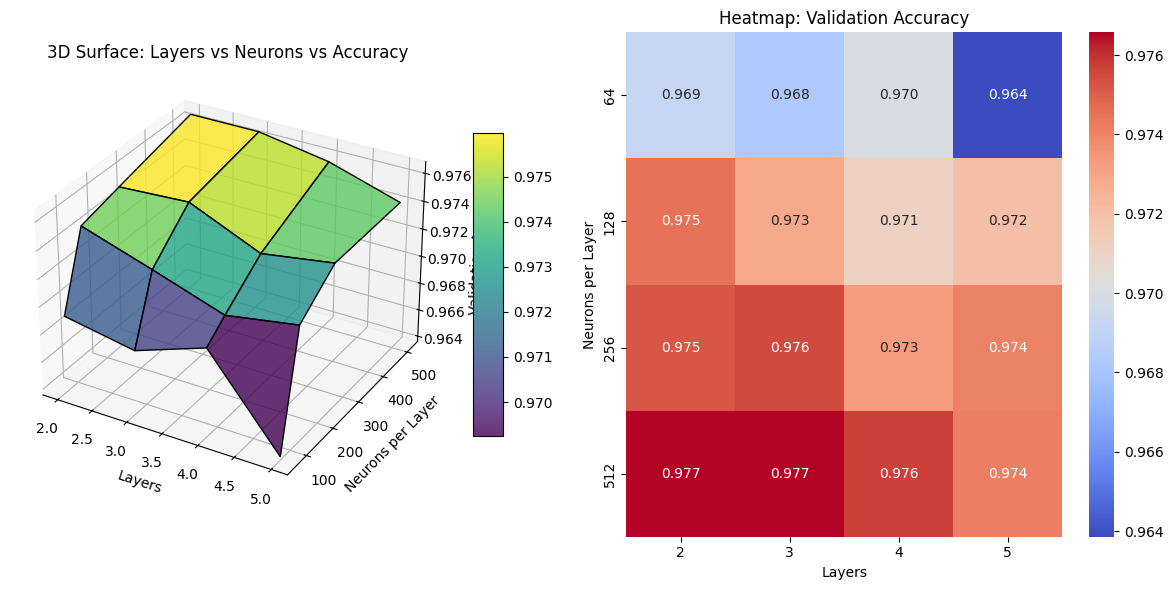

In [19]:
plot_architecture_surface(df_arch)


===== Training Final Best Model: Layers = 2, Neurons= 128, Batch Size = 64, Learning Rate= 0.01 =====
Epoch [1/50] | Train Loss: 0.9520 ± 0.5319 | Val Loss: 0.4643 ± 0.0957 | Train Acc: 0.7470, Val Acc: 0.8766
Epoch [2/50] | Train Loss: 0.3967 ± 0.0986 | Val Loss: 0.3482 ± 0.0973 | Train Acc: 0.8919, Val Acc: 0.9024
Epoch [3/50] | Train Loss: 0.3258 ± 0.0956 | Val Loss: 0.3045 ± 0.0950 | Train Acc: 0.9088, Val Acc: 0.9143
Epoch [4/50] | Train Loss: 0.2904 ± 0.0919 | Val Loss: 0.2814 ± 0.0937 | Train Acc: 0.9175, Val Acc: 0.9200
Epoch [5/50] | Train Loss: 0.2660 ± 0.0932 | Val Loss: 0.2608 ± 0.0898 | Train Acc: 0.9236, Val Acc: 0.9254
Epoch [6/50] | Train Loss: 0.2469 ± 0.0920 | Val Loss: 0.2448 ± 0.0887 | Train Acc: 0.9297, Val Acc: 0.9298
Epoch [7/50] | Train Loss: 0.2313 ± 0.0890 | Val Loss: 0.2311 ± 0.0858 | Train Acc: 0.9339, Val Acc: 0.9329
Epoch [8/50] | Train Loss: 0.2178 ± 0.0870 | Val Loss: 0.2221 ± 0.0852 | Train Acc: 0.9377, Val Acc: 0.9352
Epoch [9/50] | Train Loss: 0.2053

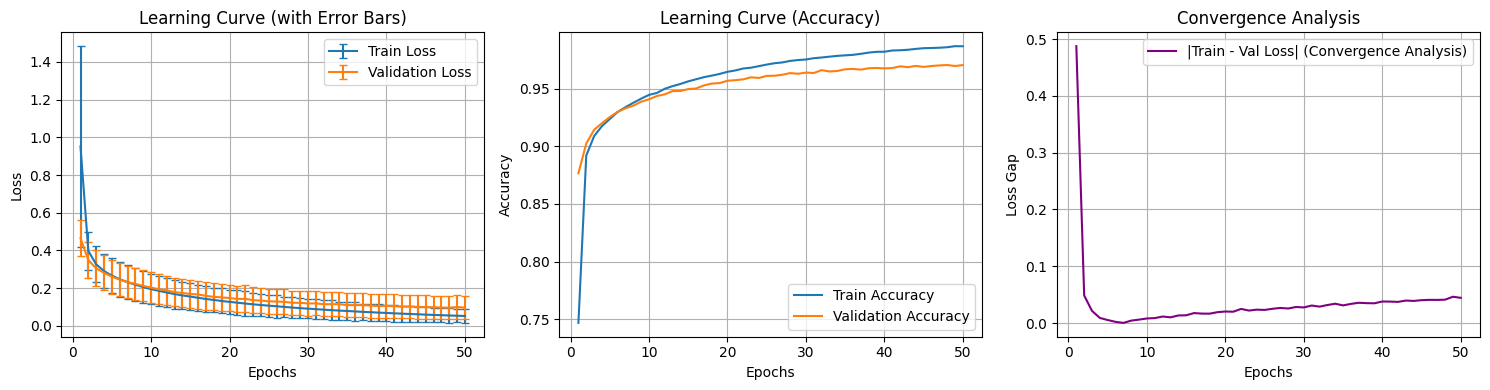

In [25]:
#best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, val_loader, test_loader = load_data('mnist_All.csv', batch_size=64)
model = NeuralNetwork(input_size=784, hidden_size=[128, 64], layers=2, output_size=10).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

print(f"\n===== Training Final Best Model: Layers = 2, Neurons= 128, "
      f"Batch Size = 64, Learning Rate= 0.01 =====")
# ---- Train final best model ----
best_model_state, train_losses, val_losses, train_std, val_std, train_acc, val_acc = model.train_model(
    train_loader, val_loader, loss_function, optimizer, epochs=50, patience=5)
# ---- Evaluate on test set ----
torch.save(best_model_state, 'best_neural_model.pth')
model.load_state_dict(best_model_state)
model.evaluate_model(test_loader, loss_function)
# Plot final results
model.plot_results(train_losses, val_losses, train_std, val_std, train_acc, val_acc)


# CNN

In [ ]:
def load_data_CNN(file_path, batch_size=64):
    data = pd.read_csv(file_path)
    Y = data['label'].values
    X = data.drop(columns=['label'], axis=1).values
    X = X / 255.0  # Normalize pixel values
    X = X.reshape(-1, 1, 28, 28)  # Reshape to (N, 1, 28, 28) for CNN input

    # Split the data 60-20-20 for train, validation, and test
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, stratify=Y, random_state=30)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=30)

    # Convert to tensors
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(Y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                torch.tensor(Y_val, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                 torch.tensor(Y_test, dtype=torch.long))

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def train_model(self, train_loader, val_loader, loss_function, optimizer, device, epochs=6, patience=3):
        train_losses, val_losses = [], []
        train_std, val_std = [], []
        train_accuracies, val_accuracies = [], []

        # Initialize early stopping tracking
        self.best_val_loss = float('inf')
        self.best_model_state = None
        self.early_stopping_counter = 0

        for epoch in range(epochs):
            self.train()
            epoch_losses = []
            correct_train, total_train = 0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            avg_train_loss = torch.tensor(epoch_losses).mean().item()
            std_train_loss = torch.tensor(epoch_losses).std().item()
            train_losses.append(avg_train_loss)
            train_std.append(std_train_loss)
            train_acc = 100 * correct_train / total_train
            train_accuracies.append(train_acc)
            
            # Validation phase
            self.eval()
            val_batch_losses = []
            correct_val, total_val = 0, 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    loss = loss_function(outputs, labels)
                    val_batch_losses.append(loss.item())

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            avg_val_loss = torch.tensor(val_batch_losses).mean().item()
            std_val_loss = torch.tensor(val_batch_losses).std().item()
            val_losses.append(avg_val_loss)
            val_std.append(std_val_loss)
            val_acc = 100 * correct_val / total_val
            val_accuracies.append(val_acc)

            # LOGGING
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} ± {std_val_loss:.4f} | "
                  f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

            # EARLY STOPPING
            if avg_val_loss < self.best_val_loss:
                self.best_val_loss = avg_val_loss
                self.best_model_state = self.state_dict()
                # torch.save(self.best_model_state, 'best_model.pth')
                self.early_stopping_counter = 0
            else:
                self.early_stopping_counter += 1
                if self.early_stopping_counter >= patience:
                    print("No improvement, stopping early.")
                    break

        return (self.best_model_state, train_losses, val_losses,
                train_std, val_std, train_accuracies, val_accuracies)


    def test_model(self, test_loader, device):
        self.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        return accuracy

    def plot_metrics(self, train_losses, val_losses, train_accuracies, val_accuracies):
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(12, 4))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, val_loader, test_loader = load_data_CNN('mnist_All.csv', batch_size=64)

model = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
best_state_CNN, train_losses_CNN, val_losses_CNN, train_std_CNN, val_std_CNN, train_accs_CNN, val_accs_CNN = model.train_model(
    train_loader, val_loader, criterion, optimizer, device, epochs=6, patience=3) 

model.load_state_dict(best_state_CNN)
model.test_model(test_loader, device)
model.plot_metrics(train_losses_CNN, val_losses_CNN, train_accs_CNN, val_accs_CNN)
torch.save(best_state_CNN, 'cnn_best_model.pth')

# Analyze the benefit of spatial feature learning

Spatial feature learning in Convolutional Neural Networks (CNNs) enables them to extract and understand spatial patterns from images by preserving structural information.

Through convolutional layers, CNNs learn local features like edges and textures, which combine into higher-level representations. 

This hierarchical approach allows CNNs to capture both local and global context efficiently. 

Weight sharing and pooling improve generalization, reduce computation, and provide robustness to translation, rotation, and scale variations. 

Overall, spatial feature learning is central to CNNs’ ability to model spatial hierarchies and achieve high performance in visual recognition tasks.

# Dropout Analysis

Dropout is a regularization technique used to prevent overfitting in neural networks.

During training, dropout randomly “turns off” (sets to zero) a fraction of neurons in a layer.

This prevents the network from relying too heavily on specific neurons or patterns.

During evaluation (validation/testing), dropout is turned off — all neurons are active, but their outputs are scaled appropriately.

Dropout helps with generalization by introducing random noise during training, which forces the model to learn more robust features.

| Dropout Rate | Train Accuracy                         | Val Accuracy | 
| ------------ | -------------------------------------- | ------------ |
| 0.1          | High train acc, slightly lower val acc | Mild         |
| 0.3          | Slightly lower train, best val acc     | Low          |
| 0.5          | Lower train acc, stable val acc        | Very low     |
| 0.7          | Poor training performance              | Underfitting |


# Mathematical Summary

---

## Objective

Dropout is a regularization technique used to prevent overfitting by randomly deactivating a subset of neurons during training.  
To ensure consistent behavior between training and testing, we scale the activations so that their expected value remains unchanged.

## Definitions

Let each neuron's activation be \( h_i \), and define a random binary variable \( r_i \) such that:

$$
r_i \sim \text{Bernoulli}(p)
$$

That is,

$$
r_i =
\begin{cases}
1, & \text{with probability } p \\
0, & \text{with probability } 1 - p
\end{cases}
$$

Here:
- \( p \): the **keep probability** (probability that a neuron remains active)
- \( 1 - p \): the **dropout rate**

## Dropout During Training

During training, dropout is applied as:

$$
\tilde{h}_i = \frac{r_i \, h_i}{p}
$$

where \( \tilde{h}_i \) is the post-dropout activation.

## Expected Activation

We require that the expected activation during training equals the original activation \( h_i \):

$$
\begin{aligned}
\mathbb{E}[\tilde{h}_i]
&= \mathbb{E}\left[\frac{r_i \, h_i}{p}\right] \\
&= \frac{h_i}{p} \, \mathbb{E}[r_i] \\
&= \frac{h_i}{p} \cdot p \\
&= h_i
\end{aligned}
$$

Therefore:

$$
\boxed{\mathbb{E}[\tilde{h}_i] = h_i}
$$

This means the expected output of each neuron remains the same, preserving the scale of activations.


## Dropout During Testing

During testing (inference), no dropout is applied:

$$
h_i^{(\text{test})} = h_i
$$

Since scaling by \( \frac{1}{p} \) was already done during training, we do not modify activations at test time.


## Without Scaling (Incorrect Case)

If we omit the scaling factor \( \frac{1}{p} \):

$$
\tilde{h}_i = r_i \, h_i
$$

then the expected activation becomes:

$$
\mathbb{E}[\tilde{h}_i] = p \, h_i
$$

which causes the neuron activations to shrink by a factor of p during training.  
At test time, this results in higher activations and inconsistent behavior between training and inference.


## Final Summary

The dropout operation is defined as:

$$
\tilde{h}_i =
\begin{cases}
\dfrac{h_i}{p}, & \text{with probability } p \\
0, & \text{with probability } 1 - p
\end{cases}
$$

and satisfies:

$$
\mathbb{E}[\tilde{h}_i] = h_i
$$

Thus, scaling by p maintains consistent expected activations across training and testing,  
ensuring stable learning and better generalization.


# Kaiming Normal Initialization (He Initialization)

**The Core Problem: Bad Initialization**

When we train a neural network, each layer transforms inputs with weights:

𝑦 = 𝑊𝑥 + 𝑏

If we choose weights poorly:

Activations can explode (grow too large)

or vanish (shrink toward 0)

or become identical (if all weights start equal, breaking learning symmetry)

This makes training slow or impossible.

So, we need to initialize weights carefully to keep signals flowing properly during forward and backward passes.

Developed by **Kaiming He et al. (2015)** for **ReLU networks**, this initialization ensures that:

- The **output variance** of each layer roughly matches the **input variance**
- This keeps activations “alive” (not too big, not too small)

#### Formula

$$
W_{ij} \sim \mathcal{N}\left(0, \frac{2}{n_{\text{in}}}\right)
$$

Where:
- n: number of input units (inputs to a neuron)
- The factor **2** compensates for the fact that **ReLU** sets about half of the activations to zero.


| Initialization          | Effect                                        |
| ----------------------- | --------------------------------------------- |
| **Zeros**               | All neurons behave identically → no learning  |
| **Random small values** | Might cause vanishing/exploding gradients     |
| **Kaiming Normal**      | Keeps activations well-scaled for ReLU layers |


Think of a deep network as a long pipe carrying information forward (activations) and backward (gradients).
If initialization is poor:

The signal fades out (too small weights)

Or blows up (too large weights)

Kaiming Normal keeps the flow balanced, especially for ReLU activations where half the neurons output 0.

| Concept                          | Meaning                               |
| -------------------------------- | ------------------------------------- |
| **Goal**                         | Prevent vanishing/exploding gradients |
| **Best for**                     | ReLU and LeakyReLU                    |
| **Weight distribution**          | Normal(0, 2 / fan_in)                 |
| **Bias**                         | Safe to initialize to 0               |
| **Alternative for Tanh/Sigmoid** | Xavier (Glorot) initialization        |


#  Fully connected Neural Network vs Conventional Neural Network (CNN)

| Aspect                      | Fully Connected Network (FNN / MLP)                                        | Convolutional Neural Network (CNN)                                            |
| --------------------------- | -------------------------------------------------------------------------- | ----------------------------------------------------------------------------- |
| **Input Handling**          | Flattens the image (e.g. 28×28 → 784 vector). Spatial structure is *lost*. | Keeps 2D structure (28×28 grid). Learns spatial patterns (edges, shapes).     |
| **Layers Used**             | Only `Linear` (dense) layers.                                              | Uses `Conv2d`, `ReLU`, `Pooling`, then `Linear`.                              |
| **Parameter Count**         | Very large (each pixel connected to every neuron).                         | Much smaller due to *weight sharing* in convolution filters.                  |
| **Feature Learning**        | Learns global patterns directly from raw pixels.                           | Learns **local features first** (edges, corners) → then global ones (digits). |
| **Translation Sensitivity** | Small shift in the image can cause large output change.                    | Convolution and pooling make it **translation-invariant**.                    |
| **Data efficiency**         | Needs more data to generalize.                                             | More data-efficient due to spatial priors.                                    |
